In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

### Guest Workshop

$\textbf{Problem 1}$: Consider a graph/network G with n nodes/agents. Voter model acts at discrete time steps $t \in {0, 1,...}$, where a node or agent is chosen uniformly at random and updates its state by copying the state of one of its nearest neighbours (in this case states take values in the set {0, 1}) also chosen uniformly at random where the update is done with some probability. The process stops once all nodes reach the same state, i.e. consensus.

I shall first implement the code to generate a random graph, since all graphs in this workshop are either fully connected or nearest neighbour connected the graphs can be represented as numpy arrays. I shall also implement a function to simulate the volter model for this generated graph.

In [2]:
def initialise_voter(n,p):
    """ We generate an initial state by drawing 0s (with probability 1-p) and 1s (with probability p), n in total."""
    graph = np.random.choice(2,n,p=[1-p,p])
    return graph

def update(graph,connectivity,i):
    """ This function updates the graph. The two options allow to choose the neighbours based on the 
    connectivity of the graph. Once the neighbour is chosen, the node will be updated based on the neighbour's
    state."""
    # i is the node to update
    if connectivity == "full":
        # fully connected graph - any node could be a neighbour
        neighbour = np.random.randint(len(graph)-1)
        if neighbour >= i:
            # shift the index if it's greater than i
            neighbour += 1
    elif connectivity == "ring":
        # 2 nearest neighbours only. Choose between one of the them.
        j = np.random.choice([-1,1])
        # choose the index of the neighbour, and apply periodic boundary conditions.
        neighbour = (i + j) % len(graph)
        
    graph[i] = graph[neighbour]
    return None

def simulate(graph,connectivity="full",t_max=100000):
    """ This function runs a single simulation, until consensus is reached. If the consensus is not reached
    within the maximal steps specified, Infinity is returned as the consensus time, and None is returned as
    the consensus value, which can be used to catch this situation."""
    
    consensus_time = np.inf
    consensus = None
    for i in range(t_max):
        sum_graph = np.sum(graph)
        # consensus is reached if all of them are 0 or all of them are 1
        if sum_graph == len(graph) or sum_graph == 0:
            consensus_time = i
            consensus = sum_graph / len(graph) # returns 0 or 1
            break
        
        # choose a random node to update
        update_node = np.random.randint(len(graph))
        # update the node
        update(graph,connectivity,update_node)
    
    return consensus_time, consensus

$\textbf{1a)}$ Consider a complete (fully connected) graph with n nodes starting from $p \in (0, 1)$ fraction of nodes in state 1. Simulate the voter model on these graphs. Plot probability of consensus at state 1 as a function of n for fixed p. Also plot the mean consensus time as a function of n for fixed p. Compare plots, do they agree with theoretical results? 

In [3]:
%%time


# An example simulation of 100 nodes, each initialised at 0 or 1 with equal probability, 0.5
g = initialise_voter(100,0.5)

ct = simulate(g)

print(f" Consensus time : {ct[0]} steps")
print(f" Consensus      : {ct[1]}")

 Consensus time : 8023 steps
 Consensus      : 1.0
Wall time: 89.5 ms


The above gives an example of a simulation of the voter model showing the time to reach consensus and the absorbing state that is reached. I shall now repeat this for different values of n, whilst keeping p fixed to produce the graphs required. I have repeated each simulation 100 times and averaged the results for good reliability.

In [4]:
n_samples = 100 # how many times we repeat each simulation
p = 0.25        # initial ratio of 1s, randomly initialised
n_max = 50      # we do the simulation with graphs of 1, 2, 3, ..., n_max nodes

# averages are collected here for the different graph size n
consensus_state = [] 
consensus_time = []

for n in tqdm(range(1,n_max+1)):
    # run the simulation with n nodes (no point using 0 nodes)
    ct_n = []
    cs_n = []
    for ns in range(n_samples):
        # each simulation is run n_sample times
        g = initialise_voter(n,p)

        ct = simulate(g,connectivity="full")
        ct_n.append(ct[0])
        cs_n.append(ct[1])

    # these arrays contain the results of the same simulation ran n_sample times
    ct_n = np.mean(ct_n)
    cs_n = np.mean(cs_n)
    
    # we collect the averages of these n_sample simulations.
    consensus_state.append(cs_n)
    consensus_time.append(ct_n)
    
consensus_state = np.array(consensus_state)
consensus_time = np.array(consensus_time)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.49it/s]


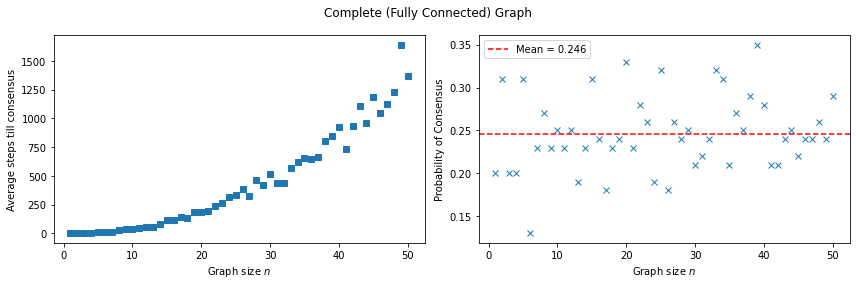

In [8]:
mean = np.mean(consensus_state)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(np.arange(1,n_max+1),consensus_time,"s")
ax1.set_xlabel(r"Graph size $n$")
ax1.set_ylabel(r"Average steps till consensus")


ax2.plot(np.arange(1, n_max+1), consensus_state, 'x')
ax2.set_xlabel(r"Graph size $n$")
ax2.set_ylabel('Probability of Consensus')
ax2.axhline(mean, ls = '--', color = 'red', label = f'Mean = {mean:.3f}')

fig.suptitle('Complete (Fully Connected) Graph')


ax2.legend()
plt.tight_layout()
plt.show()

We can see from the graph above that the probabilities of consensus are indeed inline with the theory that states that the probability of consensus of a state is the intial proportion of the state in the graph given the equal probabilities used in this set up. This is seen by the mean probability of consensus being equal to 0.25 to 2 significant figures with actual values being noramlly distributed around this value. With a greater number of iterations this would be a tighter Gaussian fit around a value closer to 0.25. 

Theory states that the average time till consensus is equivalent to: $n^{2} h(p)$ where $h(p)$ is the entropy of the state given by $h(p) = -p\text{log}(p) + (1-p)\text{log}(1-p)$ for large n. I shall calculate this and compare the values on the plot below.

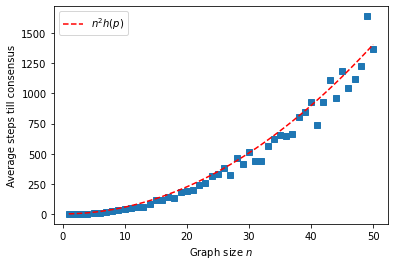

In [10]:
entropy = -(p*np.log(p) + (1-p)*np.log(1-p))
analytical_time = [entropy*(n**2) for n in range(1, n_max+1)]

fig, axes = plt.subplots(1, 1)

axes.plot(np.arange(1,n_max+1),consensus_time,"s")
axes.set_xlabel(r"Graph size $n$")
axes.set_ylabel(r"Average steps till consensus")
axes.plot(np.arange(1,n_max+1), analytical_time, ls = '--', color = 'red', label = r'$n^{2}h(p)$')
axes.legend()
plt.show()

The plot above shows that are results are indeed inline with theory as can be seen by the data following the expected function.

$\textbf{1b)}$ Repeat the above with a graph representing a ring of n nodes, i.e. where each node has two nearest neighbours, on either side of it.

In [11]:
n_samples = 100
p = 0.25
n_max = 50

ring_consensus_state = []
ring_consensus_time = []
for n in tqdm(range(1,n_max+1)):
    ring_ct_n = []
    ring_cs_n = []
    for ns in range(n_samples):
        ring_g = initialise_voter(n,p)

        ring_ct = simulate(ring_g,connectivity="ring")
        ring_ct_n.append(ring_ct[0])
        ring_cs_n.append(ring_ct[1])

    ring_ct_n = np.mean(ring_ct_n)
    ring_cs_n = np.mean(ring_cs_n)
    ring_consensus_state.append(ring_cs_n)
    ring_consensus_time.append(ring_ct_n)
    
ring_consensus_state = np.array(ring_consensus_state)
ring_consensus_time = np.array(ring_consensus_time)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:32<00:00,  4.25s/it]


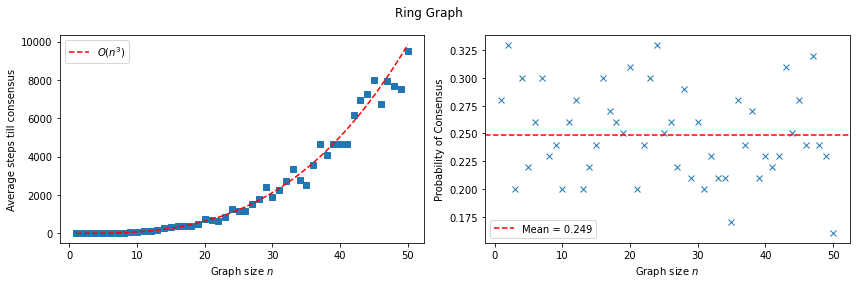

In [20]:
ring_mean = np.mean(ring_consensus_state)

entropy = -(p*np.log(p) + (1-p)*np.log(1-p))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(np.arange(1,n_max+1),ring_consensus_time,"s")
ax1.set_xlabel(r"Graph size $n$")
ax1.set_ylabel(r"Average steps till consensus")
ax1.plot(np.arange(1, n_max+1), [0.14*entropy*(n**3) for n in range(1, n_max+1)], ls = '--', color = 'red', label = r'$O(n^{3})$')

ax2.plot(np.arange(1, n_max+1), ring_consensus_state, 'x')
ax2.set_xlabel(r"Graph size $n$")
ax2.set_ylabel('Probability of Consensus')
ax2.axhline(ring_mean, ls = '--', color = 'red', label = f'Mean = {ring_mean:.3f}')


fig.suptitle('Ring Graph')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()


For the initial ring graph state we can see that again the probability, as with the completed graph, is in line with theory with measurements normally distributed among the theoretical value of 0.25. In contrast to the completed graph, the theory for the ring graph says that the average time for the ring graph is $O(n^{3})$, we can see that the data support this theory.

### Problem 2
Instead of classical voter model considered previously, consider a biased voter model where the state is updated with probability $q_j \in (0, 1)$ and retains current state with probability $1 - q_j$.

$\textbf{2a)}$
Simulate this model on a complete graph with $q_0 = 0.8$ and $q_1 = 0.4$.Plot probability with which consensus is achieved on 1 as function of n with fraction of initial agents with state 1, p fixed. How is the behaviour different to the unbiased model?

In [22]:
def update(graph,connectivity,i):
    """ This function updates the graph. The two options allow to choose the neighbours based on the 
    connectivity of the graph. Once the neighbour is chosen, the node will be updated based on the neighbour's
    state."""
    # i is the node to update
    if connectivity == "full":
        # fully connected graph - any node could be a neighbour
        neighbour = np.random.randint(len(graph)-1)
        if neighbour >= i:
            # shift the index if it's greater than i
            neighbour += 1
    elif connectivity == "ring":
        # 2 nearest neighbours only. Choose between one of the them.
        j = np.random.choice([-1,1])
        # choose the index of the neighbour, and apply periodic boundary conditions.
        neighbour = (i + j) % len(graph)
        
    graph[i] = graph[neighbour]
    return None

def weak_bias_simulate(graph, q0, q1, connectivity="full",t_max=100000):
    """ This function runs a single simulation, until consensus is reached. If the consensus is not reached
    within the maximal steps specified, Infinity is returned as the consensus time, and None is returned as
    the consensus value, which can be used to catch this situation."""
    
    consensus_time = np.inf
    consensus = None
    for i in range(t_max):
        sum_graph = np.sum(graph)
        # consensus is reached if all of them are 0 or all of them are 1
        if sum_graph == len(graph) or sum_graph == 0:
            consensus_time = i
            consensus = sum_graph / len(graph) # returns 0 or 1
            break
        
        # choose a random node to update
        update_node = np.random.randint(len(graph))
        
        #calculate wether to update
        update_prob = np.random.uniform()
        
        if graph[update_node] == 0:
            if update_prob < q0:
                update(graph,connectivity,update_node)
        else:
            if update_prob < q1:
                update(graph,connectivity,update_node)
        
    return consensus_time, consensus

In [23]:
n_samples = 100 # how many times we repeat each simulation
p = 0.25        # initial ratio of 1s, randomly initialised
n_max = 50      # we do the simulation with graphs of 1, 2, 3, ..., n_max nodes
q0 = 0.8
q1 = 0.4

# averages are collected here for the different graph size n
bias_consensus_state = [] 
bias_consensus_time = []

for n in tqdm(range(1,n_max+1)):
    # run the simulation with n nodes (no point using 0 nodes)
    bias_ct_n = []
    bias_cs_n = []
    for ns in range(n_samples):
        # each simulation is run n_sample times
        g = initialise_voter(n,p)

        bias_ct = weak_bias_simulate(g, q0, q1, connectivity="full")
        bias_ct_n.append(bias_ct[0])
        bias_cs_n.append(bias_ct[1])

    # these arrays contain the results of the same simulation ran n_sample times
    bias_ct_n = np.mean(bias_ct_n)
    bias_cs_n = np.mean(bias_cs_n)
    
    # we collect the averages of these n_sample simulations.
    bias_consensus_state.append(bias_cs_n)
    bias_consensus_time.append(bias_ct_n)
    
bias_consensus_state = np.array(bias_consensus_state)
bias_consensus_time = np.array(bias_consensus_time)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


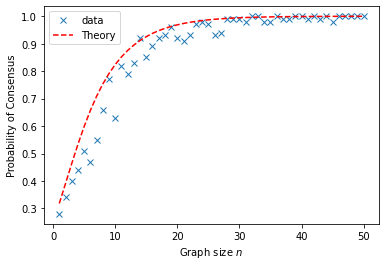

In [26]:
bias_mean = bias_consensus_state.mean()
theory_prob = [(1 - (q1/q0)**(n*p))/(1 - (q1/q0)**n) for n in range(1, n_max+1)]

fig, axes = plt.subplots(1, 1)

axes.plot(np.arange(1, n_max+1), bias_consensus_state, 'x', label = 'data')
axes.set_xlabel(r"Graph size $n$")
axes.set_ylabel('Probability of Consensus')
axes.plot(np.arange(1, n_max+1), theory_prob, ls = '--', color = 'red', label = f'Theory')
axes.legend()
plt.show()

According to theory, for the weak biased model the probability of consensus (1) is equal to:
$$P_{consensus}^{(1)} = \frac{1-(\frac{q_1}{q_0})^{A(0)}}{1-(\frac{q_1}{q_0})^{n}}$$
This has been plotted on the graph above for comparisson. We can see from this that the probabilities generated does align with theory, however the theoretical values appear to be slightly above the actual values we have calcuated.

In terms of a comparisson with the unbias voter model we can see that the linear, constant probability relationship has changed to a relationship where the probability of consensus increases as the size of the graph increases, with the probability converging to 1 for larger sized graphs. This is because as the graphs get larger the bias is more prominant so states are more likely to be changed to the biased state.

$\textbf{2b)}$ Now plot the mean consensus time as a function of n for fixed p. Verify this grows as $O(n\text{log}n)$.

From theory this relationship should be:
$$\mathbb{E}(T) = \Theta(\frac{1}{q_0 - q_1}n\text{log}n)$$.

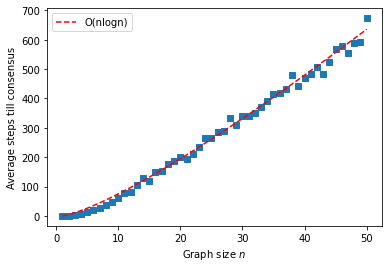

In [36]:
analytical_time = [(1/(q0-q1))*n*np.log(n) for n in range(1, n_max+1)]

fig, axes = plt.subplots(1, 1)

axes.plot(np.arange(1, n_max+1), bias_consensus_time, 's')
axes.plot(np.arange(1, n_max+1), 1.3*np.array(analytical_time), ls = '--', color = 'red', label = r'O(nlogn)')
axes.set_xlabel(r"Graph size $n$")
axes.set_ylabel(r"Average steps till consensus")
axes.legend()
plt.show()

Can see from the plot above that the data for the mean consensus time does indeed increase inline with the trend suggested by the theory as described above.

### Problem 3

Now consider model where at each time step a uniformly chosen node/agent updates its state to state 1 with probability $\alpha \in (0, 1)$ irrespective of its current state and the states of its neighbours. With probability $1-\alpha$ the node performs an update according to the 2-choices rule. The 2-choices rule samples 2 of its neighbours randomly and takes the majority opinion within the group formed of the 2 sampled neighbours and the updating agent itself. This model represents strong bias in the 2-choices model and so the only stable consensus state is the all-1 state.

$\textbf{3a)}$ Simulate this model on a complete graph with value of $\alpha$ higher than 1/9 starting from all agents having state 0 initially. Plot the mean consensus time as a function of n. Verify that the mean consensus time grows as $O(n\text{log}n)$.

In [37]:
def two_choice_update(graph,i):
    """ This function updates the graph."""
    # i is the node to update
    no_i_graph = graph[[indx != i for indx in range(0, len(graph))]]
    neighbours = np.random.choice(no_i_graph, 2, replace = False)
    
    average = (neighbours[0] + neighbours[1] + graph[i])/3
    if average > 0.5:
        graph[i] = 1
    else:
        graph[i] = 0
    return None

def two_choice_simulate(graph, alpha, t_max=100000):
    """ This function runs a single simulation, until consensus is reached. If the consensus is not reached
    within the maximal steps specified, Infinity is returned as the consensus time, and None is returned as
    the consensus value, which can be used to catch this situation."""
    
    consensus_time = np.inf
    consensus = None
    for i in range(t_max):
        sum_graph = np.sum(graph)
        # consensus is reached if all of them are 0 or all of them are 1
        if sum_graph == len(graph):
            consensus_time = i
            consensus = sum_graph / len(graph) # returns 0 or 1
            break
        
        # choose a random node to update
        update_node = np.random.randint(len(graph))
        #implement strong bias
        strong_bias_prob = np.random.uniform()
        if strong_bias_prob < alpha:
            graph[update_node] = 1
        else:
            two_choice_update(graph,update_node)
    
    return consensus_time, consensus

In [56]:
n_samples = 100 # how many times we repeat each simulation
n_max = 50      # we do the simulation with graphs of 1, 2, 3, ..., n_max nodes
alpha = 2/9

# averages are collected here for the different graph size n
strong_bias_consensus_state = [] 
strong_bias_consensus_time = []

for n in tqdm(range(3,n_max+1)):
    # run the simulation with n nodes (no point using 0 nodes)
    strong_bias_ct_n = []
    strong_bias_cs_n = []
    for ns in range(n_samples):
        # each simulation is run n_sample times
        g = np.zeros(shape = n)

        strong_bias_ct = two_choice_simulate(g, alpha)
        strong_bias_ct_n.append(strong_bias_ct[0])
        strong_bias_cs_n.append(strong_bias_ct[1])

    # these arrays contain the results of the same simulation ran n_sample times
    strong_bias_ct_n = np.mean(strong_bias_ct_n)
    strong_bias_cs_n = np.mean(strong_bias_cs_n)
    
    # we collect the averages of these n_sample simulations.
    strong_bias_consensus_state.append(strong_bias_cs_n)
    strong_bias_consensus_time.append(strong_bias_ct_n)
    
strong_bias_consensus_state = np.array(strong_bias_consensus_state)
strong_bias_consensus_time = np.array(strong_bias_consensus_time)

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.47it/s]


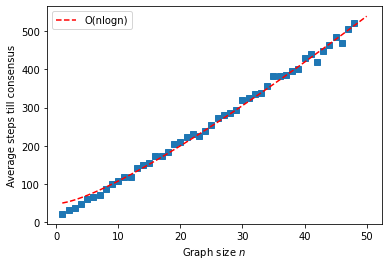

In [60]:
fig, axes = plt.subplots(1, 1)

strong_analytical_time = [n*np.log(n) for n in range(1, n_max+1)]
axes.plot(np.arange(1, n_max-1), strong_bias_consensus_time, 's')
axes.plot(np.arange(1, n_max+1), 2.5*np.array(strong_analytical_time)+50, ls = '--', color = 'red', label = r'O(nlogn)')
axes.set_xlabel(r"Graph size $n$")
axes.set_ylabel(r"Average steps till consensus")
axes.legend()
plt.show()

The graph above shows that at large n the average time till consensus of the strongly biased 2 choice model does increased as expected from the theory. However at small graph sizes the trend appears to be more linear than is suggested by the theory.

$\textbf{3b)}$ Repeat the same model with a value of $\alpha$ less than 1/9. Verify the mean consensus time grows exponentially in this case.

In [67]:
alpha = 0.05
n_max = 20

# averages are collected here for the different graph size n
strong_bias_consensus_state1 = [] 
strong_bias_consensus_time1 = []

for n in tqdm(range(3,n_max+1)):
    # run the simulation with n nodes (no point using 0 nodes)
    strong_bias_ct_n1 = []
    strong_bias_cs_n1 = []
    for ns in range(n_samples):
        # each simulation is run n_sample times
        g = np.zeros(shape = n)

        strong_bias_ct1 = two_choice_simulate(g, alpha)
        strong_bias_ct_n1.append(strong_bias_ct1[0])
        strong_bias_cs_n1.append(strong_bias_ct1[1])

    # these arrays contain the results of the same simulation ran n_sample times
    strong_bias_ct_n1 = np.mean(strong_bias_ct_n1)
    strong_bias_cs_n1 = np.mean(strong_bias_cs_n1)
    
    # we collect the averages of these n_sample simulations.
    strong_bias_consensus_state1.append(strong_bias_cs_n1)
    strong_bias_consensus_time1.append(strong_bias_ct_n1)
    
strong_bias_consensus_state1 = np.array(strong_bias_consensus_state1)
strong_bias_consensus_time1 = np.array(strong_bias_consensus_time1)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:51<00:00,  9.56s/it]


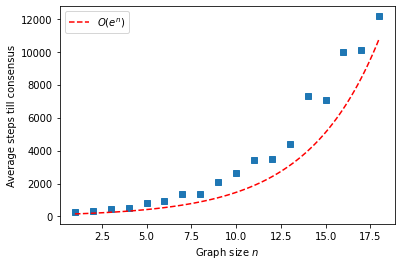

In [102]:
fig, axes = plt.subplots(1, 1)

n_range = np.linspace(1, n_max-2, 100)
exp_analytical_time = [np.exp(n) for n in range(1, n_max-1)]
axes.plot(np.arange(1, n_max-1), strong_bias_consensus_time1, 's')
axes.plot(n_range, 120*np.exp(n_range/4), ls = '--', color = 'red', label = r'$O(e^{n})$')
axes.set_xlabel(r"Graph size $n$")
axes.set_ylabel(r"Average steps till consensus")
axes.legend()
plt.show()

The plot above shows that the consensus time does increase as bounded by an exponential order as suggested by theory for the value of $\alpha < \frac{1}{9}$. I have reduce the x range representing the size of the the graphs used for this plot as due to the exponential nature each subsequently larger graph measured takes increasingly greater times.

$\textbf{3c)}$ The above two plots show the phase transition that occurs across the boundary (actually at $\alpha = 1/9$). Can you give an intuitive reason to explain this phase transition?

The phase transition is occuring due to two competing factors represented by the $\alpha$ parameter, these being the individual influence vs the network dynamics. When alpha is large, there is a large probability of the state independantly changing towards the biased state and so the individual influence is large and thus convergence is fast. However, as alpha decreases there becomes a point where the probability of a node randomly changing to the biased state is so low with subsequently the probability of the two choices model being followed being high, as the initial state is in all zeros the two choices model (effectively majority voting) is likely to keep returning zeros meaning the time taken is very large.

To sum this up, at large alpha we are both more likely to have a node change straight to a 0 to a 1 and so subsequently even if this does not happen, we are more likley to have a greater concetration of 1's in the state array meaning that there is a greater probability of the two choices model giving a 1, leading to an overall greater convergence speed. Conversely, at low alpha, the two choices model is most likely applied which due to the initial states all being zeros will more than likely return zeros, so we are relying on the low probability of the string bias to flip some 0's to 1's repatedly before any sort of convergence can be seen, thus this is a much longer convergence time.